# Afro-XLMR-Large + Sentiment Head (English CE, baseline)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
%cd "/content/drive/MyDrive/Carnegie_Mellon_University/Fall_2025/11711/Project"

In [16]:
!pip install -q transformers pandas scikit-learn

import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel

In [17]:
CSV_PATH = "/content/drive/MyDrive/Carnegie_Mellon_University/Fall_2025/11711/Project/Datasets/EN_ZU_1000.csv"

df = pd.read_csv(CSV_PATH)

print("Columns:", df.columns.tolist())
print("Total samples:", len(df))

# Show first 10 rows
print(df[["review_en", "review_zu", "sentiment_bin"]].head(10))

Columns: ['review_en', 'sentiment_bin', 'review_zu']
Total samples: 1000
                                           review_en  \
0  The hotel was a far cry from the advertising o...   
1  Pool was out of order, basketball hoop broke. ...   
2  Needed somewhere to stay for a last minute bus...   
3  There was not a good selection for breakfast t...   
4  I don't think I need to say more. Holiday Inn ...   
5  There were about 5 bugs in the room and a gian...   
6  Breakfast was supposed to last until 9:30. My ...   
7  We stayed here for 2 nights. The staff did all...   
8  Cute place, nice jacuzzi and pool, great coffe...   
9  The hotel staff was extremely friendly. This h...   

                                           review_zu sentiment_bin  
0  Ihhotela lalikhashane kakhulu nokukhangisa kul...      negative  
1  I-pool yayingavumelekile, i-basketball hoop ya...      negative  
2  Kwakudingeka indawo yokuhlala ukuze uhambe ngo...      negative  
3  Kwakungekho ukukhetha okuhle kw

In [18]:
# Map sentiment strings to integers
label2id = {"negative": 0, "positive": 1}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["sentiment_bin"].map(label2id)

# 10% test set
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    random_state=42,
    stratify=df["label"]
)

# Split remaining 90% into train/val (~80% / 10%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1111,
    random_state=42,
    stratify=train_val_df["label"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Train size: 800
Val size: 100
Test size: 100


In [19]:
class ENZUJointDataset(Dataset):
    def __init__(self, df):
        self.en = df["review_en"].tolist()
        self.zu = df["review_zu"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "en": self.en[idx],
            "zu": self.zu[idx],
            "label": self.labels[idx],
        }

train_dataset = ENZUJointDataset(train_df)
val_dataset   = ENZUJointDataset(val_df)
test_dataset  = ENZUJointDataset(test_df)

In [20]:
MODEL_NAME = "Davlan/afro-xlmr-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoder   = AutoModel.from_pretrained(MODEL_NAME)

hidden_size = encoder.config.hidden_size
num_labels = 2

Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
class EnglishOnlySentimentModel(nn.Module):
    def __init__(self, encoder, hidden_size, num_labels=2):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(hidden_size, num_labels)

    def encode(self, input_ids, attention_mask):
        """
        Encode sentences and return a single vector per sentence (CLS token).
        """
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls = outputs.last_hidden_state[:, 0]  # [batch, hidden_size]
        return cls

    def forward(self, en_inputs, labels=None):
        """
        Forward pass using ENGLISH inputs only.

        If labels is provided -> returns (loss, logits, embeddings).
        If labels is None   -> returns (logits, embeddings).
        """
        h_en = self.encode(**en_inputs)
        logits_en = self.classifier(h_en)

        if labels is None:
            return logits_en, h_en

        # English-only cross-entropy
        ce_en = F.cross_entropy(logits_en, labels)
        return ce_en, logits_en, h_en

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnglishOnlySentimentModel(encoder, hidden_size, num_labels).to(device)

batch_size    = 16
num_epochs    = 6
learning_rate = 2e-5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [33]:
def encode_batch(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

In [34]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        en_texts = batch["en"]
        labels   = batch["label"].to(device)

        en_inputs = encode_batch(en_texts)
        en_inputs = {k: v.to(device) for k, v in en_inputs.items()}

        optimizer.zero_grad()

        loss, logits_en, h_en = model(en_inputs, labels=labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation on EN
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            en_texts = batch["en"]
            labels   = batch["label"].to(device)

            en_inputs = encode_batch(en_texts)
            en_inputs = {k: v.to(device) for k, v in en_inputs.items()}

            logits_en, h_en = model(en_inputs, labels=None)
            preds = logits_en.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    val_acc = correct / total if total > 0 else 0.0
    print(f"Epoch {epoch+1}/{num_epochs} | train loss: {avg_train_loss:.4f} | val EN acc: {val_acc:.4f}")

Epoch 1/6 | train loss: 0.6406 | val EN acc: 0.7600
Epoch 2/6 | train loss: 0.4061 | val EN acc: 0.7100
Epoch 3/6 | train loss: 0.3520 | val EN acc: 0.8300
Epoch 4/6 | train loss: 0.2179 | val EN acc: 0.8500
Epoch 5/6 | train loss: 0.1433 | val EN acc: 0.8600
Epoch 6/6 | train loss: 0.1166 | val EN acc: 0.8500


In [35]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
all_preds = []
all_labels = []
all_texts = []

with torch.no_grad():
    for batch in test_loader:
        zu_texts = batch["zu"]
        labels   = batch["label"].to(device)

        zu_inputs = encode_batch(zu_texts)
        zu_inputs = {k: v.to(device) for k, v in zu_inputs.items()}

        # Encode Zulu and classify with the same head
        h_zu = model.encode(**zu_inputs)
        logits_zu = model.classifier(h_zu)
        preds = logits_zu.argmax(dim=-1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        all_texts.extend(zu_texts)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = (all_preds == all_labels).mean()
print(f"\nZulu test accuracy (English-only baseline): {test_acc:.4f}")


Zulu test accuracy (English-only baseline): 0.6900


In [36]:
target_names = [id2label[0], id2label[1]]
print("\nClassification report (Zulu test set, English-only baseline):\n")
print(classification_report(all_labels, all_preds, target_names=target_names))


Classification report (Zulu test set, English-only baseline):

              precision    recall  f1-score   support

    negative       0.64      0.66      0.65        44
    positive       0.73      0.71      0.72        56

    accuracy                           0.69       100
   macro avg       0.69      0.69      0.69       100
weighted avg       0.69      0.69      0.69       100



In [37]:
print("\n--- 10 Zulu test samples with predictions (English-only baseline) ---\n")
n_show = min(10, len(all_texts))

for i in range(n_show):
    print(f"Sample {i+1}")
    print("Zulu text             :", all_texts[i])
    print("Ground-truth label    :", id2label[all_labels[i]])
    print("Predicted             :", id2label[all_preds[i]])
    print("-" * 80)


--- 10 Zulu test samples with predictions (English-only baseline) ---

Sample 1
Zulu text             : Leli gumbi lalinomthamo omuhle kodwa lalidala futhi lidala, futhi indawo eyayikuyo yayingacacile, okusho ukuthi, kwakunikeza amakhasimende amasha futhi kwakufanelekile ukubhadalelwa.
Ground-truth label    : negative
Predicted             : negative
--------------------------------------------------------------------------------
Sample 2
Zulu text             : Ngokuvamile, kwaba okuhlangenwe nakho okumnandi.
Ground-truth label    : negative
Predicted             : positive
--------------------------------------------------------------------------------
Sample 3
Zulu text             : Igumbi lalingenawo umshini wokuphatha umoya. Umthombo womoya omusha kuphela kwakuwukuvula iwindi. Iningi lazo zonke ezinye izivakashi lalinamafasitela avulekile futhi umsindo ovela kwezinye izivakashi wawuzwakala kakhulu. Umculo onomsindo omkhulu owawuvela kuzo zonke izinhlangothi. Isembozo sewindi sas

# Afro-XLMR-Large + Sentiment Head (English CE + Contrastive Loss)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Carnegie_Mellon_University/Fall_2025/11711/Project"

/content/drive/MyDrive/Carnegie_Mellon_University/Fall_2025/11711/Project


In [ ]:
!pip install -q transformers pandas scikit-learn

import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel

In [ ]:
CSV_PATH = "/content/drive/MyDrive/Carnegie_Mellon_University/Fall_2025/11711/Project/Datasets/EN_ZU_1000.csv"

df = pd.read_csv(CSV_PATH)

# Columns: review_en, sentiment_bin, review_zu
print("Columns:", df.columns.tolist())
print("Dataset size:", len(df))

# Print first 10 samples
print(df[["review_en", "review_zu", "sentiment_bin"]].head(10))

Columns: ['review_en', 'sentiment_bin', 'review_zu']
Dataset size: 1000
                                           review_en  \
0  The hotel was a far cry from the advertising o...   
1  Pool was out of order, basketball hoop broke. ...   
2  Needed somewhere to stay for a last minute bus...   
3  There was not a good selection for breakfast t...   
4  I don't think I need to say more. Holiday Inn ...   
5  There were about 5 bugs in the room and a gian...   
6  Breakfast was supposed to last until 9:30. My ...   
7  We stayed here for 2 nights. The staff did all...   
8  Cute place, nice jacuzzi and pool, great coffe...   
9  The hotel staff was extremely friendly. This h...   

                                           review_zu sentiment_bin  
0  Ihhotela lalikhashane kakhulu nokukhangisa kul...      negative  
1  I-pool yayingavumelekile, i-basketball hoop ya...      negative  
2  Kwakudingeka indawo yokuhlala ukuze uhambe ngo...      negative  
3  Kwakungekho ukukhetha okuhle kwa

In [ ]:
# Map sentiment strings to integers
label2id = {"negative": 0, "positive": 1}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["sentiment_bin"].map(label2id)

# 10% Zulu test set
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    random_state=42,
    stratify=df["label"]
)

# Split remaining into train/val (~80/10)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1111,
    random_state=42,
    stratify=train_val_df["label"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Train size: 800
Val size: 100
Test size: 100


In [ ]:
class ENZUJointDataset(Dataset):
    def __init__(self, df):
        self.en = df["review_en"].tolist()
        self.zu = df["review_zu"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "en": self.en[idx],
            "zu": self.zu[idx],
            "label": self.labels[idx],
        }

train_dataset = ENZUJointDataset(train_df)
val_dataset   = ENZUJointDataset(val_df)
test_dataset  = ENZUJointDataset(test_df)

In [ ]:
MODEL_NAME = "Davlan/afro-xlmr-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoder   = AutoModel.from_pretrained(MODEL_NAME)

hidden_size = encoder.config.hidden_size
num_labels = 2

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class SentimentContrastiveModel(nn.Module):
    def __init__(self, encoder, hidden_size, num_labels=2):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(hidden_size, num_labels)

    def encode(self, input_ids, attention_mask):
        """
        Encode sentences and return a single vector per sentence.
        Here we take the [CLS] token (position 0).
        """
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls = outputs.last_hidden_state[:, 0]
        return cls

    def forward(self, en_inputs, zu_inputs, labels=None,
                alpha=0.1, temperature=0.05):
        """
        Forward with joint loss.

        - Sentiment classification on EN embeddings (cross-entropy).
        - Contrastive alignment between EN and ZU embeddings.

        If labels is None: just returns logits on EN (useful for inference).
        """
        # Encode EN and ZU batches
        h_en = self.encode(**en_inputs)
        h_zu = self.encode(**zu_inputs)

        # Sentiment logits from EN
        logits = self.classifier(h_en)

        if labels is None:
            return logits, h_en, h_zu

        # 1) Sentiment classification loss (English)
        ce_loss = F.cross_entropy(logits, labels)

        # 2) Contrastive loss (EN <-> ZU)
        contr_loss = contrastive_loss(h_en, h_zu, temperature=temperature)

        # Total joint loss
        loss = ce_loss + alpha * contr_loss

        return loss, logits, h_en, h_zu

In [ ]:
def contrastive_loss(z_en, z_zu, temperature=0.05):
    # Normalize
    z_en = F.normalize(z_en, p=2, dim=-1)
    z_zu = F.normalize(z_zu, p=2, dim=-1)

    # Similarity matrix [B, B]
    logits = torch.matmul(z_en, z_zu.T) / temperature

    # True index for each pair
    batch_size = z_en.size(0)
    labels = torch.arange(batch_size, device=z_en.device)

    # EN->ZU and ZU->EN
    loss_i = F.cross_entropy(logits, labels)
    loss_j = F.cross_entropy(logits.T, labels)

    return 0.5 * (loss_i + loss_j)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentContrastiveModel(encoder, hidden_size, num_labels).to(device)

batch_size = 16
num_epochs = 6
learning_rate = 2e-5
alpha = 0.1
temperature = 0.05

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
def encode_batch(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        en_texts = batch["en"]
        zu_texts = batch["zu"]
        labels   = batch["label"].to(device)

        en_inputs = encode_batch(en_texts)
        zu_inputs = encode_batch(zu_texts)

        en_inputs = {k: v.to(device) for k, v in en_inputs.items()}
        zu_inputs = {k: v.to(device) for k, v in zu_inputs.items()}

        optimizer.zero_grad()
        loss, logits, h_en, h_zu = model(
            en_inputs, zu_inputs,
            labels=labels,
            alpha=alpha,
            temperature=temperature
        )
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Simple validation accuracy on EN
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            en_texts = batch["en"]
            labels   = batch["label"].to(device)

            en_inputs = encode_batch(en_texts)
            en_inputs = {k: v.to(device) for k, v in en_inputs.items()}

            logits, _, _ = model(en_inputs, en_inputs, labels=None)
            preds = logits.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    val_acc = correct / total if total > 0 else 0.0
    print(f"Epoch {epoch+1}/{num_epochs} | train loss: {avg_train_loss:.4f} | val EN acc: {val_acc:.4f}")

Epoch 1/6 | train loss: 0.8228 | val EN acc: 0.7600
Epoch 2/6 | train loss: 0.8739 | val EN acc: 0.6300
Epoch 3/6 | train loss: 0.8280 | val EN acc: 0.7900
Epoch 4/6 | train loss: 0.7097 | val EN acc: 0.7700
Epoch 5/6 | train loss: 0.6514 | val EN acc: 0.6000
Epoch 6/6 | train loss: 0.8927 | val EN acc: 0.6900


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
all_preds = []
all_labels = []
all_texts = []

with torch.no_grad():
    for batch in test_loader:
        zu_texts = batch["zu"]
        labels   = batch["label"].to(device)

        zu_inputs = encode_batch(zu_texts)
        zu_inputs = {k: v.to(device) for k, v in zu_inputs.items()}

        # Encode Zulu and classify
        h_zu = model.encode(**zu_inputs)
        logits = model.classifier(h_zu)
        preds = logits.argmax(dim=-1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        all_texts.extend(zu_texts)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Test accuracy
test_acc = (all_preds == all_labels).mean()
print(f"\nZulu test accuracy: {test_acc:.4f}")


Zulu test accuracy: 0.7400


In [ ]:
target_names = [id2label[0], id2label[1]]
print("\nClassification report (Zulu test set):\n")
print(classification_report(all_labels, all_preds, target_names=target_names))


Classification report (Zulu test set):

              precision    recall  f1-score   support

    negative       0.88      0.48      0.62        44
    positive       0.70      0.95      0.80        56

    accuracy                           0.74       100
   macro avg       0.79      0.71      0.71       100
weighted avg       0.78      0.74      0.72       100



In [ ]:
print("\n--- 10 Zulu test samples with predictions ---\n")
n_show = min(10, len(all_texts))

for i in range(n_show):
    print(f"Sample {i+1}")
    print("Zulu text             :", all_texts[i])
    print("Ground-truth label    :", id2label[all_labels[i]])
    print("Predicted             :", id2label[all_preds[i]])
    print("-" * 80)


--- 10 Zulu test samples with predictions ---

Sample 1
Zulu text             : Leli gumbi lalinomthamo omuhle kodwa lalidala futhi lidala, futhi indawo eyayikuyo yayingacacile, okusho ukuthi, kwakunikeza amakhasimende amasha futhi kwakufanelekile ukubhadalelwa.
Ground-truth label    : negative
Predicted             : positive
--------------------------------------------------------------------------------
Sample 2
Zulu text             : Ngokuvamile, kwaba okuhlangenwe nakho okumnandi.
Ground-truth label    : negative
Predicted             : positive
--------------------------------------------------------------------------------
Sample 3
Zulu text             : Igumbi lalingenawo umshini wokuphatha umoya. Umthombo womoya omusha kuphela kwakuwukuvula iwindi. Iningi lazo zonke ezinye izivakashi lalinamafasitela avulekile futhi umsindo ovela kwezinye izivakashi wawuzwakala kakhulu. Umculo onomsindo omkhulu owawuvela kuzo zonke izinhlangothi. Isembozo sewindi sasiphakama cishe amasentim

# Afro-XLMR-Large + Sentiment Head (English CE + Contrastive Loss + Zulu CE)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Carnegie_Mellon_University/Fall_2025/11711/Project"

/content/drive/MyDrive/Carnegie_Mellon_University/Fall_2025/11711/Project


In [3]:
!pip install -q transformers pandas scikit-learn

import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel

In [4]:
CSV_PATH = "/content/drive/MyDrive/Carnegie_Mellon_University/Fall_2025/11711/Project/Datasets/EN_ZU_1000.csv"

df = pd.read_csv(CSV_PATH)

print("Columns:", df.columns.tolist())
print("Total samples:", len(df))

# Show first 10 rows
print(df[["review_en", "review_zu", "sentiment_bin"]].head(10))

Columns: ['review_en', 'sentiment_bin', 'review_zu']
Total samples: 1000
                                           review_en  \
0  The hotel was a far cry from the advertising o...   
1  Pool was out of order, basketball hoop broke. ...   
2  Needed somewhere to stay for a last minute bus...   
3  There was not a good selection for breakfast t...   
4  I don't think I need to say more. Holiday Inn ...   
5  There were about 5 bugs in the room and a gian...   
6  Breakfast was supposed to last until 9:30. My ...   
7  We stayed here for 2 nights. The staff did all...   
8  Cute place, nice jacuzzi and pool, great coffe...   
9  The hotel staff was extremely friendly. This h...   

                                           review_zu sentiment_bin  
0  Ihhotela lalikhashane kakhulu nokukhangisa kul...      negative  
1  I-pool yayingavumelekile, i-basketball hoop ya...      negative  
2  Kwakudingeka indawo yokuhlala ukuze uhambe ngo...      negative  
3  Kwakungekho ukukhetha okuhle kw

In [5]:
# Map sentiment strings to integers
label2id = {"negative": 0, "positive": 1}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["sentiment_bin"].map(label2id)

# 10% test set
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    random_state=42,
    stratify=df["label"]
)

# Split remaining 90% into train/val (~80% / 10%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1111,
    random_state=42,
    stratify=train_val_df["label"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Train size: 800
Val size: 100
Test size: 100


In [6]:
class ENZUJointDataset(Dataset):
    def __init__(self, df):
        self.en = df["review_en"].tolist()
        self.zu = df["review_zu"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "en": self.en[idx],
            "zu": self.zu[idx],
            "label": self.labels[idx],
        }

train_dataset = ENZUJointDataset(train_df)
val_dataset   = ENZUJointDataset(val_df)
test_dataset  = ENZUJointDataset(test_df)

In [7]:
MODEL_NAME = "Davlan/afro-xlmr-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoder   = AutoModel.from_pretrained(MODEL_NAME)

hidden_size = encoder.config.hidden_size
num_labels = 2

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def contrastive_loss(z_en, z_zu, temperature=0.05):
    # L2-normalize (cosine similarity)
    z_en = F.normalize(z_en, p=2, dim=-1)
    z_zu = F.normalize(z_zu, p=2, dim=-1)

    # Similarity matrix [B, B]
    logits = torch.matmul(z_en, z_zu.T) / temperature

    batch_size = z_en.size(0)
    labels = torch.arange(batch_size, device=z_en.device)

    # EN -> ZU and ZU -> EN
    loss_i = F.cross_entropy(logits,     labels)
    loss_j = F.cross_entropy(logits.T,   labels)

    return 0.5 * (loss_i + loss_j)

In [9]:
class SentimentContrastiveModel(nn.Module):
    def __init__(self, encoder, hidden_size, num_labels=2):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(hidden_size, num_labels)

    def encode(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # CLS pooling
        cls = outputs.last_hidden_state[:, 0]
        return cls

    def forward(self, en_inputs, zu_inputs,
                labels=None,
                alpha=0.1,
                beta=1.0,
                temperature=0.05):
        """
        Joint forward:
        - English CE (logits_en vs labels)
        - Zulu CE (logits_zu vs labels)
        - Contrastive loss between EN & ZU embeddings
        """
        h_en = self.encode(**en_inputs)
        h_zu = self.encode(**zu_inputs)

        logits_en = self.classifier(h_en)
        logits_zu = self.classifier(h_zu)

        if labels is None:
            return logits_en, logits_zu, h_en, h_zu

        # English CE
        ce_en = F.cross_entropy(logits_en, labels)

        # Zulu CE
        ce_zu = F.cross_entropy(logits_zu, labels)

        # Contrastive EN<->ZU
        contr = contrastive_loss(h_en, h_zu, temperature=temperature)

        # Joint loss
        loss = ce_en + beta * ce_zu + alpha * contr

        return loss, logits_en, logits_zu, h_en, h_zu

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentContrastiveModel(encoder, hidden_size, num_labels).to(device)

batch_size   = 16
num_epochs   = 6
learning_rate = 2e-5
alpha = 0.1
beta  = 1.0
temperature = 0.05

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [11]:
def encode_batch(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

In [12]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        en_texts = batch["en"]
        zu_texts = batch["zu"]
        labels   = batch["label"].to(device)

        en_inputs = encode_batch(en_texts)
        zu_inputs = encode_batch(zu_texts)

        en_inputs = {k: v.to(device) for k, v in en_inputs.items()}
        zu_inputs = {k: v.to(device) for k, v in zu_inputs.items()}

        optimizer.zero_grad()

        loss, logits_en, logits_zu, h_en, h_zu = model(
            en_inputs, zu_inputs,
            labels=labels,
            alpha=alpha,
            beta=beta,
            temperature=temperature
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            en_texts = batch["en"]
            zu_texts = batch["zu"]
            labels   = batch["label"].to(device)

            en_inputs = encode_batch(en_texts)
            zu_inputs = encode_batch(zu_texts)

            en_inputs = {k: v.to(device) for k, v in en_inputs.items()}
            zu_inputs = {k: v.to(device) for k, v in zu_inputs.items()}

            logits_en, logits_zu, h_en, h_zu = model(
                en_inputs, zu_inputs,
                labels=None
            )

            preds = logits_zu.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    val_acc = correct / total if total > 0 else 0.0
    print(f"Epoch {epoch+1}/{num_epochs} | train loss: {avg_train_loss:.4f} | val ZU acc: {val_acc:.4f}")

Epoch 1/6 | train loss: 1.8753 | val ZU acc: 0.5600
Epoch 2/6 | train loss: 1.5540 | val ZU acc: 0.7300
Epoch 3/6 | train loss: 1.3580 | val ZU acc: 0.6600
Epoch 4/6 | train loss: 1.1355 | val ZU acc: 0.8100
Epoch 5/6 | train loss: 0.9006 | val ZU acc: 0.8100
Epoch 6/6 | train loss: 0.6968 | val ZU acc: 0.7900


In [13]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
all_preds = []
all_labels = []
all_texts = []

with torch.no_grad():
    for batch in test_loader:
        zu_texts = batch["zu"]
        labels   = batch["label"].to(device)

        zu_inputs = encode_batch(zu_texts)
        zu_inputs = {k: v.to(device) for k, v in zu_inputs.items()}

        # Encode Zulu and classify
        h_zu = model.encode(**zu_inputs)
        logits_zu = model.classifier(h_zu)
        preds = logits_zu.argmax(dim=-1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        all_texts.extend(zu_texts)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = (all_preds == all_labels).mean()
print(f"\nZulu test accuracy: {test_acc:.4f}")


Zulu test accuracy: 0.7900


In [14]:
target_names = [id2label[0], id2label[1]]
print("\nClassification report (Zulu test set):\n")
print(classification_report(all_labels, all_preds, target_names=target_names))


Classification report (Zulu test set):

              precision    recall  f1-score   support

    negative       0.83      0.66      0.73        44
    positive       0.77      0.89      0.83        56

    accuracy                           0.79       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.79      0.79       100



In [15]:
print("\n--- 10 Zulu test samples with predictions ---\n")
n_show = min(10, len(all_texts))

for i in range(n_show):
    print(f"Sample {i+1}")
    print("Zulu text             :", all_texts[i])
    print("Ground-truth label    :", id2label[all_labels[i]])
    print("Predicted             :", id2label[all_preds[i]])
    print("-" * 80)


--- 10 Zulu test samples with predictions ---

Sample 1
Zulu text             : Leli gumbi lalinomthamo omuhle kodwa lalidala futhi lidala, futhi indawo eyayikuyo yayingacacile, okusho ukuthi, kwakunikeza amakhasimende amasha futhi kwakufanelekile ukubhadalelwa.
Ground-truth label    : negative
Predicted             : negative
--------------------------------------------------------------------------------
Sample 2
Zulu text             : Ngokuvamile, kwaba okuhlangenwe nakho okumnandi.
Ground-truth label    : negative
Predicted             : positive
--------------------------------------------------------------------------------
Sample 3
Zulu text             : Igumbi lalingenawo umshini wokuphatha umoya. Umthombo womoya omusha kuphela kwakuwukuvula iwindi. Iningi lazo zonke ezinye izivakashi lalinamafasitela avulekile futhi umsindo ovela kwezinye izivakashi wawuzwakala kakhulu. Umculo onomsindo omkhulu owawuvela kuzo zonke izinhlangothi. Isembozo sewindi sasiphakama cishe amasentim

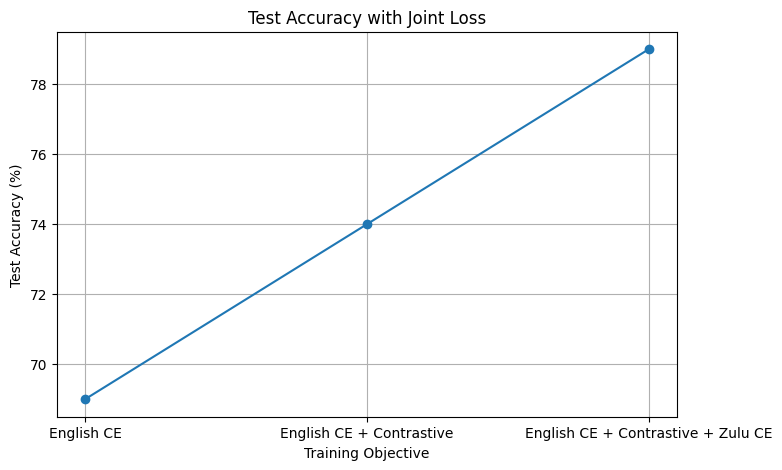

In [2]:
import matplotlib.pyplot as plt

# X and Y values
x_values = ["English CE",
            "English CE + Contrastive",
            "English CE + Contrastive + Zulu CE"]
y_values = [69, 74, 79]

plt.figure(figsize=(8,5))
plt.plot(x_values, y_values, marker='o')

plt.title("Test Accuracy with Joint Loss")
plt.xlabel("Training Objective")
plt.ylabel("Test Accuracy (%)")

plt.grid(True)
plt.show()